# Comparing the different velocity components betwen N2Hp and HC3N

In [1]:
import numpy as np
import os
import pandas as pd

import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord, FK5
from astropy.visualization.wcsaxes import add_beam, add_scalebar
from reproject import reproject_interp

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import cm
from matplotlib.colors import AsinhNorm

from copy import copy
from scipy import stats
from scipy.integrate import simpson
%matplotlib widget

In [2]:
velcubehc3nfile = '../bayes_frame/nested-sampling/HC3N/vel_components_cube_filtered_QA.fits'
velcuben2hpfile = '../bayes_frame/nested-sampling/N2Hp/vel_components_cube_filtered_QA.fits'
mlex1n2hpfile = '../bayes_frame/nested-sampling/N2Hp/NGC1333-SE-mle-x1_filtered_QA.fits'
mlex2n2hpfile = '../bayes_frame/nested-sampling/N2Hp/NGC1333-SE-mle-x2_filtered_QA.fits' # _QA
mom0n2hpfile = '../data/NGC1333-N2Hp_match_kms_F1F_01_12_K_5_10_mom0.fits' #mom0 of the files used to fit the spectra
mom0hc3nfile = '../data/NGC1333_HC3N_L24-merged_small_K_-3.0_18.0_mom0.fits'
sourcecat = '../data/Tobin_2018_Perseus_cat_NGC1333SE.csv'

diffminfile = 'NGC1333-SE_HC3N-N2Hp_mindiff.fits'
kdefile = 'NGC1333-SE_HC3N-N2Hp'

In [3]:
# here we load the N2Hp data
velcuben2hp, headervelcuben2hp = fits.getdata(velcuben2hpfile, header=True)
velcuben2hp1, velcuben2hp2 = velcuben2hp
headern2hp = fits.getheader(mom0n2hpfile)
wcssky = WCS(headern2hp).celestial
#catalog of protostars
catalog_protostars = pd.read_csv(sourcecat)

In [4]:
# here we load the files in their original grid and reproject
if not os.path.exists(velcubehc3nfile[:-5]+'_reproject.fits'):
    velcubehc3n, headervelcubehc3n = fits.getdata(velcubehc3nfile, header=True)
    headerhc3n = fits.getheader(mom0hc3nfile)
    velcubehc3n1, velcubehc3n2, velcubehc3n3 = velcubehc3n
    velcubehc3n1new, velfootprint = reproject_interp(fits.PrimaryHDU(data=velcubehc3n1, header=headerhc3n), headern2hp)
    velcubehc3n2new, _footprint = reproject_interp(fits.PrimaryHDU(data=velcubehc3n2, header=headerhc3n), headern2hp)
    velcubehc3n3new, _footprint = reproject_interp(fits.PrimaryHDU(data=velcubehc3n3, header=headerhc3n), headern2hp)
    velcubehc3nnew = [velcubehc3n1new, velcubehc3n2new, velcubehc3n3new]
    # building the new header
    headervelcubehc3nnew = headervelcubehc3n.copy()
    headervelcubehc3nnew['NAXIS1'] = headern2hp['NAXIS1']
    headervelcubehc3nnew['NAXIS2'] = headern2hp['NAXIS2']
    headervelcubehc3nnew['CDELT1'] = headern2hp['CDELT1']
    headervelcubehc3nnew['CDELT2'] = headern2hp['CDELT2']
    headervelcubehc3nnew['CRVAL1'] = headern2hp['CRVAL1']
    headervelcubehc3nnew['CRVAL2'] = headern2hp['CRVAL2']
    headervelcubehc3nnew['CRPIX1'] = headern2hp['CRPIX1']
    headervelcubehc3nnew['CRPIX2'] = headern2hp['CRPIX2']
    # save the results
    fits.writeto(velcubehc3nfile[:-5]+'_reproject.fits', velcubehc3nnew, headervelcubehc3nnew, overwrite=True)
else:
    velcubehc3nnew, headervelcubehc3nnew = fits.getdata(velcubehc3nfile[:-5]+'_reproject.fits', header=True)
    velcubehc3n1new, velcubehc3n2new, velcubehc3n3new = velcubehc3nnew


In [5]:
# now that they have the same projection, we can compare the velocity.
# we subtract HC3N from N2Hp to see the relative movement of HC3N with respect to N2Hp
deltav1 = velcubehc3n1new - velcuben2hp1
deltahc3n1nh2 = velcubehc3n1new - velcuben2hp2 # most of the HC3N has one component
deltav2 =  velcubehc3n2new - velcuben2hp2 
deltahc3n2nh1 = velcubehc3n1new - velcuben2hp1
deltahc3n3nh2 = velcubehc3n3new - velcuben2hp2

print('Basic info:')
print('Maximum difference between comp.1', np.nanmax(deltav1))
print('Maximum negative difference between comp.1', np.nanmin(deltav1))
print('Average difference between comp.1', np.nanmean(deltav1))

print('Maximum difference between comp.2', np.nanmax(deltav2))
print('Maximum negative difference between comp.2', np.nanmin(deltav2))
print('Average difference between comp.2', np.nanmean(deltav2))

Basic info:
Maximum difference between comp.1 3.4045161374018464
Maximum negative difference between comp.1 -4.711799675725532
Average difference between comp.1 0.20154666810278113
Maximum difference between comp.2 0.8047745814555931
Maximum negative difference between comp.2 -2.2427939123381497
Average difference between comp.2 -0.06920901793096317


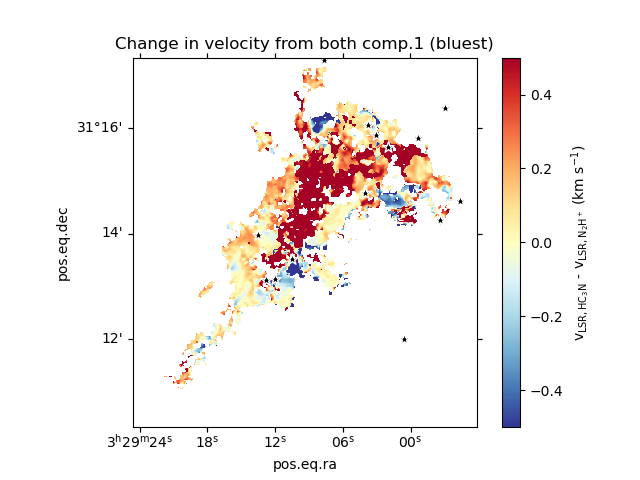

In [6]:
vmin =-0.5
vmax = 0.5


fig = plt.figure()
ax = fig.add_subplot(111, projection=wcssky)

im = ax.imshow(deltav1, cmap='RdYlBu_r', interpolation='nearest', vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax, label=r'v$_{\mathrm{LSR, HC}_3\mathrm{N}}$ - v$_{\mathrm{LSR, N}_2\mathrm{H}^+}$ (km s$^{-1}$)')
ax.set_title('Change in velocity from both comp.1 (bluest)')
for i in catalog_protostars.index.values:
    ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
               transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70)
    
fig.savefig('comparison_blueshifted_comps_HC3NminusN2Hp.pdf', dpi=100, bbox_inches='tight')

From this plot we see that HC3N does not cover the middle part of the bluest component of N2Hp, so the two velocity layers are one over the other in N2Hp **but not in HC3N**. This is important for later comparison

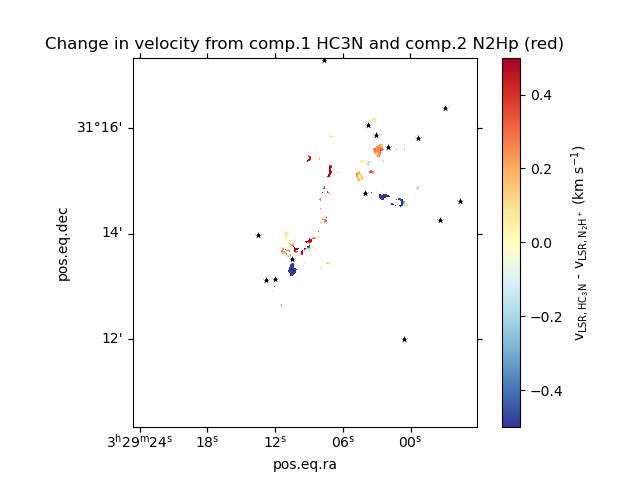

In [7]:
vmin =-0.5
vmax = 0.5


fig = plt.figure()
ax = fig.add_subplot(111, projection=wcssky)

im = ax.imshow(deltav2, cmap='RdYlBu_r', interpolation='nearest', vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax, label=r'v$_{\mathrm{LSR, HC}_3\mathrm{N}}$ - v$_{\mathrm{LSR, N}_2\mathrm{H}^+}$ (km s$^{-1}$)')
ax.set_title('Change in velocity from comp.1 HC3N and comp.2 N2Hp (red)')
for i in catalog_protostars.index.values:
    ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
               transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70)
    
fig.savefig('comparison_redshifted_comps_HC3NminusN2Hp.pdf', dpi=100, bbox_inches='tight')

In [8]:
# we take the minimum difference to see the true distribution, as HC3N is mostly in two layers that do not overlap
xarray = np.linspace(0, headervelcuben2hp['NAXIS1']-1, headervelcuben2hp['NAXIS1']).astype(int)
yarray = np.linspace(0, headervelcuben2hp['NAXIS2']-1, headervelcuben2hp['NAXIS2']).astype(int)
deltavarray = np.array([deltav1, deltahc3n2nh1, deltahc3n1nh2, deltav2, deltahc3n3nh2]) #all in comparison to the bluest n2hp first
deltavmin = np.zeros(np.shape(deltav1)) * np.nan
signarray = np.sign(deltavarray)
indexminarray = np.zeros(np.shape(deltav1)) * np.nan
for x in xarray:
    for y in yarray:
        if np.all(np.isnan(deltavarray[:,y,x])): continue
        else:
            indexmin = np.nanargmin(np.abs(deltavarray[:, y, x]))
            indexminarray[y,x] = indexmin
            deltavmin[y,x] = deltavarray[indexmin, y, x]
            
            
# deltavmin = np.where(~np.isnan(deltav1) & np.isnan(deltav2), deltav1, np.nan) # we first fill with the values that only have one option
# indexv1 = np.where(~np.isnan(deltav1) & ~np.isnan(deltav2) & (np.abs(deltav1)<np.abs(deltav2)))
# indexv2 = np.where(~np.isnan(deltav1) & ~np.isnan(deltav2) & (np.abs(deltav1)>=np.abs(deltav2)))

deltavminmedian = np.nanmedian(deltavmin)
# for y, x in zip(indexv1[0], indexv1[1]):
#     deltavmin[y, x] = deltav1[y, x]
# for y, x in zip(indexv2[0], indexv2[1]):
#     deltavmin[y, x] = deltav2[y, x]
    
if not os.path.exists(diffminfile):
    headerdiffmin = headern2hp.copy()
    headerdiffmin['BUNIT'] = 'km s-1'
    fits.writeto(diffminfile, deltavmin, headerdiffmin)


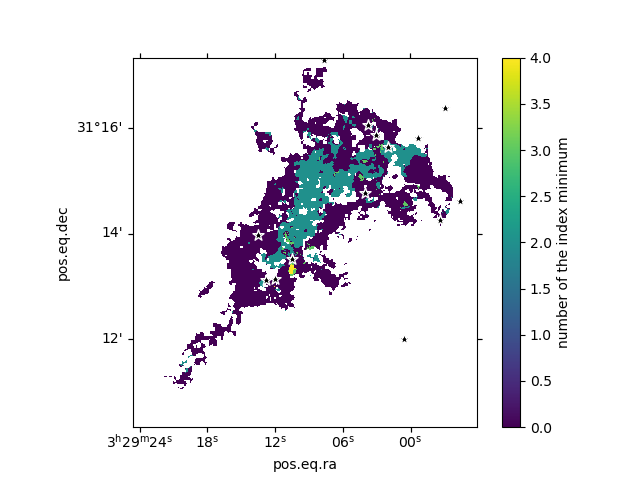

In [9]:

fig = plt.figure()
ax = fig.add_subplot(111, projection=wcssky)

im = ax.imshow(indexminarray, cmap='viridis', interpolation='nearest')
fig.colorbar(im, ax=ax, label=r'number of the index minimum')
# ax.set_title('Minimum change in velocity between HC$_3$ and N$_2$H$^+$')
for i in catalog_protostars.index.values:
    ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
               transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70)
#     
fig.savefig('comparison_mindiff_comps_HC3NminusN2Hp.pdf', dpi=100, bbox_inches='tight')

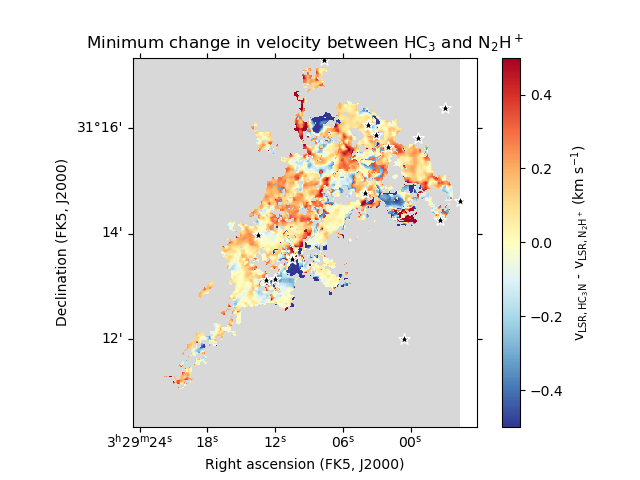

In [10]:
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.85')
vmin = -0.5
vmax= 0.5

fig = plt.figure()
ax = fig.add_subplot(111, projection=wcssky)

im = ax.imshow(deltavmin, cmap=cmap, interpolation='nearest', vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax, label=r'v$_{\mathrm{LSR, HC}_3\mathrm{N}}$ - v$_{\mathrm{LSR, N}_2\mathrm{H}^+}$ (km s$^{-1}$)')
ax.set_title('Minimum change in velocity between HC$_3$ and N$_2$H$^+$')
for i in catalog_protostars.index.values:
    ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
               transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70)

    
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (FK5, J2000)')
lat.set_axislabel('Declination (FK5, J2000)')
fig.savefig('comparison_mindiff_comps_HC3NminusN2Hp.pdf', dpi=100, bbox_inches='tight')

In [11]:
# we take the KDE to see if the difference is significant
#this is the difference kde

if not os.path.exists(kdefile+'_histdiff.npy'):
    data_kde = np.linspace(-1.0, 1.0, 100)
    data = deltavmin.flatten()
    data = data[~np.isnan(data)]
    p_range = np.array([0.15865 * 100, 50., 0.84135 * 100]) # one sigma
    diff_median_unc = np.round(np.percentile(data, p_range), decimals=2)

    kernel = stats.gaussian_kde(data)
    dens_diff = kernel(data_kde)
    dens_diff /= simpson(dens_diff, data_kde) # normalizing of probability

    datasave = np.array([data_kde, dens_diff, diff_median_unc], dtype=object)

    np.save(kdefile+'_histdiff.npy', datasave)
else:
    datasave = np.load(kdefile+'_histdiff.npy', allow_pickle=True)
    data_kde, dens_diff, diff_median_unc = datasave

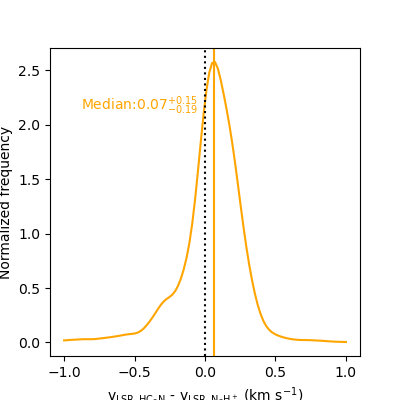

In [12]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

ax.plot(data_kde, dens_diff, color='orange')
ax.axvline(0, color='k', linestyle='dotted')
ax.axvline(deltavminmedian, color='orange')
ax.annotate(r'Median:'+ str(np.round(diff_median_unc[1], 3)) 
            + r'$^{+' +str(np.round(diff_median_unc[2]-diff_median_unc[1], 3))+'}_{-'+str(np.round(diff_median_unc[1]-diff_median_unc[0], 3)) + r'}$', (0.1, 0.8), xycoords='axes fraction', color='orange')

ax.set_xlabel(r'v$_{\mathrm{LSR, HC}_3\mathrm{N}}$ - v$_{\mathrm{LSR, N}_2\mathrm{H}^+}$ (km s$^{-1}$)')
ax.set_ylabel('Normalized frequency')

fig.savefig('KDE_diff_min.pdf', bbox_inches='tight')

In [13]:
# we take the KDE to see if the difference is significant
hc3nkde = np.zeros(np.shape(velcubehc3n1new))*np.nan
n2hpkde = np.zeros(np.shape(velcubehc3n1new))*np.nan
# unfortunately this takes one value per pixel, but there are very few places where HC3N has 2 components so we do not miss anything
for y in range(len(n2hpkde)):
    for x in range(len(n2hpkde[0])):
        if np.isnan(indexminarray[y,x]): continue
        else:
            if indexminarray[y,x]==0:
                hc3nkde[y,x] = velcubehc3n1new[y,x]
                n2hpkde[y,x] = velcuben2hp1[y,x]
            elif indexminarray[y,x]==1:
                hc3nkde[y,x] = velcubehc3n2new[y,x]
                n2hpkde[y,x] = velcuben2hp1[y,x]
            elif indexminarray[y,x]==2:
                hc3nkde[y,x] = velcubehc3n1new[y,x]
                n2hpkde[y,x] = velcuben2hp2[y,x]
            elif indexminarray[y,x]==3:
                hc3nkde[y,x] = velcubehc3n2new[y,x]
                n2hpkde[y,x] = velcuben2hp2[y,x]
            else:
                hc3nkde[y,x] = velcubehc3n3new[y,x]
                n2hpkde[y,x] = velcuben2hp2[y,x]
                
# for y, x in zip(indexv1[0], indexv1[1]):
#     n2hpkde[y, x] = velcuben2hp1[y, x]
# for y, x in zip(indexv2[0], indexv2[1]):
#     n2hpkde[y, x] = velcuben2hp2[y, x]
    
if not os.path.exists(kdefile+'.npy'):
    #x is vlsr of HC3N
    xmin = 6
    xmax = 9.5
    # y is v_LSR of 2Hp
    ymin = 6
    ymax = 9.5
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    # we select only those who are not nan
    gd_vlos = np.isfinite(hc3nkde * n2hpkde)
    values = np.vstack([hc3nkde[gd_vlos], n2hpkde[gd_vlos]])
    # we calculate the kernel distribution
    kernel = stats.gaussian_kde(values)
    zz = np.reshape(kernel(positions).T, xx.shape)
    zz /= zz.max()

    datasave = np.array([xx, yy, zz])

    np.save(kdefile+'.npy', datasave)
else:
    datasave = np.load(kdefile+'.npy')
    xx, yy, zz = datasave

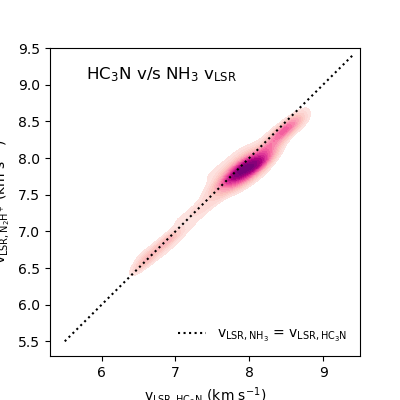

In [14]:
def shifted_line(velx, shift):
    return velx + shift
linesample = np.linspace(5.5,9.4, 10)
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.contourf(xx, yy, zz, cmap='RdPu', levels=np.arange(0.1, 1.2, 0.05), vmin=0., vmax=1.1)
ax.set_xlabel(r'v$_{\mathrm{LSR}, \mathrm{HC}_3\mathrm{N}}$ (km s$^{-1}$)')
ax.set_ylabel(r'v$_{\mathrm{LSR}, \mathrm{N}_2\mathrm{H}^+}$ (km s$^{-1}$)')
ax.plot(linesample, linesample, 'k:', label='v$_{\mathrm{LSR}, \mathrm{NH}_3}$ = v$_{\mathrm{LSR}, \mathrm{HC}_3\mathrm{N}}$')
ax.annotate('\n HC$_3$N v/s NH$_{3}$ v$_{\mathrm{LSR}}$', (0.1, 0.9), xycoords='axes fraction', size=12)
# ax.set_xlim([4, 11])
# ax.set_ylim([4, 11])
ax.legend(frameon=False, loc=4)
# $\mathrm{V}_{LSR, \mathrm{HC}_3\mathrm{N}} - \mathrm{V}_{LSR, \mathrm{NH}_3}$
fig.savefig('KDE_vlsr_min.pdf', bbox_inches='tight')